In [1]:
GPU_DEVICE = -1#Please set the GPU device you want to use to execute this notebook -1 means CPU

# Adversarial images
In this notebook we will have a look at the vulnerability for adversarial examples of the networks learned in 'training GAN' and 'training supervised network' notebooks. First we will use the supervised model to generate adversarial examples and see how vulnerable this network is to these examples. Next we will use the same examples to test the vulnerability of the descriminator learned by the GAN.

In [2]:
import math
import json
import numpy as np
import chainer, os, collections, six, math, random, time, copy,sys
from chainer import cuda, Variable, optimizers, serializers, function, optimizer, initializers
from chainer.utils import type_check
from chainer import functions as F
from chainer import links as L
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

### Helper functions and constants
Here i will define some helper functions that we might want to use for both the supervised network and the gan network

In [3]:
# These are the epsilons value we will calculate adversarial images of i also generate them with epsilon 0.
# This gives me the original images and make my life a little easier when obtaining the results
GRADIENT_STEPS = [0.0,.1,.25,1.] 

# Column names for the to be generated csvs
COLS = ['index','org_index','loss','eps','correct','found_label','confidence'] + ['prob_' + str(x) for x in range(10)]

def _build_labels(p, label,eps):
    """ Helper function to build label for under the image, shows the certainty 
    with which the image is classified as a certain integer
    """
    return ("%d(%.2f%%)" % (label, p*100.0), "$\epsilon$:%.2f" % eps)

def _plot_image(i,ax, text_a,text_b):
    """ Plots a gray scale image with some text under it
    text_a is first line
    text_b is second line
    """
    i = i.reshape(28,28)
    ax.imshow(i,cmap='gray')
    ax.axis('off')
    ax.annotate(text_a, xy=(0, 0), xytext=(2, 32))
    ax.annotate(text_b, xy=(0, 0), xytext=(7, 36))

def plot_images(imgs,confidence,labels,eps=GRADIENT_STEPS):
    """ Plots multiple images with the probablity of the correct class and the probablity of the target adv class
    """
    ni = len(imgs)
    fig, axarr = plt.subplots(ncols=ni)
    for i in range(ni):
        correct_label = labels[i]
        p = confidence[i]
        text_a,text_b = _build_labels(p, correct_label,eps[i])
        _plot_image(imgs[i,:],axarr[i],text_a,text_b )
    
    
def statistics_from_df(df):
    """ Gets statistics( average confidence and accuracy) for every possible value of epsilon
    return als list of tuples (eps, average confidence, accuracy)
    """
    data = []
    for eps in GRADIENT_STEPS:
        # get all fields for this
        s = df[df.eps == eps]
        p = s[s.correct == s.found_label]
        
        acc = float(p.shape[0])/s.shape[0]
        data.append((eps, acc, np.average(s.confidence.tolist())))
    return data

def statistics_to_latex_table(data):
    """ Can be used to print data as table
    """
    print "\\begin{tabular}{|l|l|l|}\hline"
    print " & ".join(["\\textbf{"+x+"}" for x in ['type','accuracy','avg. confidence']]) + "\\\\\hline"
    for d in data:
        X = list(d)
        print  " & ".join(["$\epsilon = %.2f$" % d[0]] +["%.3f" % x for x in X[1:]]) + "\\\\\hline"
    print "\end{tabular}"

## Supervised network
Now  load the normal supervised neural network and see how it works out
### Loading model

In [4]:
# Network definition
class MLP(chainer.Chain):

    def __init__(self, n_out):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, 1000),  # n_in -> n_units
            l2=L.Linear(None, 500),  # n_units -> n_units
            l3=L.Linear(None, 250),  # n_units -> n_units
            l4=L.Linear(None, n_out),  # n_units -> n_out
        )

    def __call__(self, x):
        h1 = F.elu(self.l1(x))
        h2 = F.elu(self.l2(h1))
        h3 = F.elu(self.l3(h2))
        return self.l4(h3)

In [5]:
model = L.Classifier(MLP( 10))
resume = 'result/model.npz'
if GPU_DEVICE >= 0:
    chainer.cuda.get_device(GPU_DEVICE).use()  # Make a specified GPU current
    model.to_gpu()  # Copy the model to the GPU

chainer.serializers.load_npz(resume, model)

## Some helper functions

In [6]:
# Helper functions that help to translate between chainer variable and numpy variables
def _to_variable(x):
    if isinstance(x, Variable) == False:
        x = Variable(x)
        if GPU_DEVICE > -1:
            x.to_gpu()
    return x

def _to_numpy(x):
    if isinstance(x, Variable) == True:
        x = x.data
    if isinstance(x, cuda.ndarray) == True:
        x = cuda.to_cpu(x)
    return x   

def pass_forward_sup(ims, target_labels, calc_gradients = False):
    """ This passes images forward trough the network. Using the target_labels 
    it will also calculate the loss. If calc_gradients is set to True it will 
    calculate the gradiens with respect to the input
    
    Returns a tuple containing loss, probabilities and optionally gradients
    """
    ims = _to_variable(ims)
    
    target = _to_variable(target_labels)
    # predict loss
    loss = model(ims, target)
    if calc_gradients:
        # back propagate error
        loss.backward()
        
        return _to_numpy(loss), _to_numpy(F.softmax(model.y)), ims.grad
    else:
        # model.predictor contains our original model, without the classifier class
        return _to_numpy(loss), _to_numpy(F.softmax(model.predictor(ims)))
        
def create_adv_images(ims, sgrad, eps):
    """ Given original images, signed gradient matrix and a epsilon will 
    calculate the new adversarial images.
    Will also make sure the matrix is constraint to a minimum of 0 and a max of 1
    """
    return np.minimum(
        np.ones(shape=ims.shape, dtype=np.float32), 
        np.maximum(
            np.zeros(shape=ims.shape,dtype=np.float32), 
            ims + np.multiply(eps,sgrad)
        )
    )
            
        

### Generate adversarial images and a csv file with the results
We will now create the following numpy array:
- images array  all generated adversarial images, for every possible $\epsilon$ value
- all_probs holding all found probalities for every class for every adversarial image
- org_probs holding all originally found probabilties, only for the non adversarial images

We will also create a csv using pandas with the following columns:
- index: Index in the images and all_probs array
- org_index: index in the org_probs array and the MNIST dataset of the original image
- loss: loss for this step
- eps: Used epsilon value for this adversarial image
- correct: original label for this image
- found_label: the label with the highest probablity for this image
- Confidence: the probability of the found label
- prob_0 t/m prob_10: probabilities found for all classes

This csv can be used to obtain results.

In [7]:
# download mnist dataset
train, test = chainer.datasets.get_mnist()

# Number of original images to walk over
N_IMAGES = len(test)
#keep data for csv dataframe
data = []

#Keep index of last created adversarial image
image_idx  = 0

#empty array that can hold all generated adversarial images
images = np.zeros((len(GRADIENT_STEPS)*N_IMAGES,28**2)) 
#empty array that hold all probabiliteis for all genareted images
all_probs = np.zeros((len(GRADIENT_STEPS)*N_IMAGES,10),dtype=np.float32) 

#empty array that keeps track of all original probabilities
org_probs = np.zeros((N_IMAGES,10),dtype=np.float32)

#Walk over the training image in batches of 128
for i in range(0,int(math.ceil(N_IMAGES/128.))):
    #start indexes of this batch
    s = i * 128
    # ends s+128 or N_images
    e = min(s+128,N_IMAGES)
    n = e-s
    
    #dataset consists of list of tuples, first element of tuple contains image 
    #second contains label
    ins = test[s:e]
    imgs = np.array([i[0] for i in ins])
    labs = np.array([i[1] for i in ins],dtype=np.int32)
    
    # Calculate original probs and gradient with respect to input 
    loss, probs, gradients = pass_forward_sup(imgs, labs, True)
    
    # Adversarial images are generated using the signed gradient
    sgrad = np.sign(gradients)
    
    # Save original probabilities, for later display
    org_probs[s:e,:] = probs
    
    # we will generate the adversarial images in 
    for step in GRADIENT_STEPS:
        # build images
        advi = create_adv_images(imgs, sgrad, step)
        # passes forward, giving probabilities and loss 
        loss, probs = pass_forward_sup(advi,labs)
        # Loss is sum of loss of all different samples: should be corrected for batch size
        loss = loss / n
        # found labels with max probability
        found_labels = np.argmax(probs,axis=1)
        #walk over the 128 images seperately 
        for x in range(n):
            #save iamges and probablities
            images[image_idx,:] = advi[x]
            all_probs[image_idx,:] = probs[x]
            
            #to csv
            data.append([image_idx,s+x,loss, step, labs[x], found_labels[x],probs[x,found_labels[x]]] + probs[x,:].tolist())
            image_idx +=1
#save to csv       
df = pd.DataFrame(data=data, columns=COLS)
df.to_csv('supervised_images.csv', encoding='utf8')

#save to npz files
np.savez('supervised_advs.npz',images=images,org_probs=org_probs,all_probs=all_probs)

### Showing adversarial images
I plot all versions of the two images that are wrongly classified with $\epsilon \geq 0.1$ and two that are wrongly classified with $\epsilon \geq 0.25$.


Wrongly classified eps >= 0.1 [9344, 7597]
Wrongly classified eps >= 0.25 [9780, 5866]


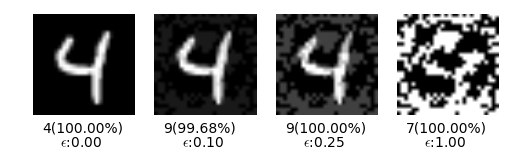

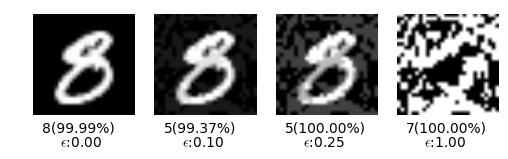

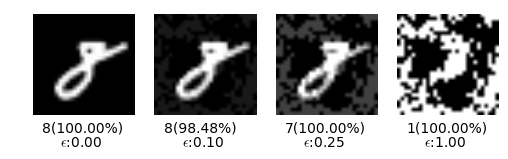

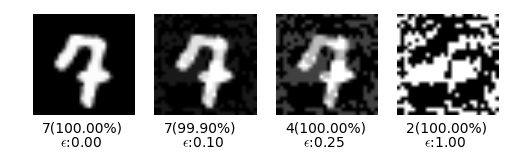

In [8]:
def _plot_for(org_ids):
    for org_id in org_ids:
        selected_img = df[df.org_index == org_id].sort_values('eps')
        imgs = np.take(images,selected_img.index.tolist(),axis=0)
        conf = selected_img.confidence.tolist()
        found_labels = selected_img.found_label.tolist()
        plot_images(imgs, conf, found_labels)
        
incorrect = df[df.found_label != df.correct] #select that are classified correclty

# incorrectly classified anyway
incorrect_eps_0 = incorrect[incorrect.eps == 0.0] 

# Incorrectly classified with eps=0.1
incorrect_eps_1 = incorrect[(incorrect.eps == 0.1) & (incorrect.org_index.isin(incorrect_eps_0.org_index) == False)]
idx = incorrect_eps_1.sample(2).org_index.tolist()
print "Wrongly classified eps >= 0.1", idx
_plot_for(idx)

# Incorrecly classfied with eps=0.25
incorrect_eps_25 = incorrect[(incorrect.eps == 0.25)   & (incorrect.org_index.isin(incorrect_eps_0.org_index) == False) & (incorrect.org_index.isin(incorrect_eps_1.org_index) == False)]
idx = incorrect_eps_25.sample(2).org_index.tolist()
print "Wrongly classified eps >= 0.25", idx
_plot_for(idx)

In [9]:
stats = statistics_from_df(df)
statistics_to_latex_table(stats)

\begin{tabular}{|l|l|l|}\hline
\textbf{type} & \textbf{accuracy} & \textbf{avg. confidence}\\\hline
$\epsilon = 0.00$ & 0.981 & 0.994\\\hline
$\epsilon = 0.10$ & 0.537 & 0.956\\\hline
$\epsilon = 0.25$ & 0.306 & 0.965\\\hline
$\epsilon = 1.00$ & 0.142 & 0.988\\\hline
\end{tabular}


## GAN
To keep this notebook readable we import the scripts directly from python. Please see training GAN for more details about the GAN code used. We will doe this experiment twice. Once with a 250 epoch trained network once with discriminator trained for a 1000 epochs. In order to reproduce you would have to change lines below

In [10]:
repo_root = os.path.join(os.path.split(os.getcwd())[0],'improved-gan')
mnist_root = os.path.join(repo_root,'train_mnist')

# Overwrite system arguments such that argparse in train_mnist/args.py works correctly
#1000 epochs
#sys.argv = ['main','-g',str(GPU_DEVICE),'-m',os.path.join(mnist_root,'mnist'),'-p',os.path.join(mnist_root,'mnist_plot')]
#250 epoch
sys.argv = ['main','-g',str(GPU_DEVICE),'-m',os.path.join(mnist_root,'mnist_250'),'-p',os.path.join(mnist_root,'mnist_plot_250')]


In [11]:

# add the imported repository to the path both the general code and the train_mnist specific code
sys.path.append(repo_root)
sys.path.append(os.path.join(repo_root,'train_mnist'))

from gan import *
from params import *
# This will load the gan and the parameters learned during training
from model import gan
import mnist_tools


/Users/stijnvoss/Documents/UNI/CCN/git/end-assignment
loading /Users/stijnvoss/Documents/UNI/CCN/git/end-assignment/improved-gan/train_mnist/mnist_250/discriminator.json
loading /Users/stijnvoss/Documents/UNI/CCN/git/end-assignment/improved-gan/train_mnist/mnist_250/generator.json
loading /Users/stijnvoss/Documents/UNI/CCN/git/end-assignment/improved-gan/train_mnist/mnist_250/generator.hdf5 ...
loading /Users/stijnvoss/Documents/UNI/CCN/git/end-assignment/improved-gan/train_mnist/mnist_250/discriminator.hdf5 ...


## Load adversarial images

In [12]:
data = np.load('supervised_advs.npz')
images = data['images']
supervised_df = pd.read_csv('supervised_images.csv', encoding='utf8')

In [13]:
def pass_forward_desc(ims, target_classes):
    """ Will pass a batch of images trough the descriminator, will calculate loss and probabilities
    """
    # converting to chainer variable makes sure we can obtain gradient
    ims = gan.to_variable(ims) 
    
    #Now pass forward trough the network and get probs, we do not use softmax since chainer only seems
    #to provide a cross entropy softmax loss function
    probs, activations = gan.discriminate(ims,test=True,apply_softmax=False) 
    # our cross entropy function that will calculate the loss also need chainer var
    labels = gan.to_variable(target_classes)  

    # Here we calculate the loss
    loss = F.softmax_cross_entropy(probs, labels) 

    return gan.to_numpy(loss),gan.to_numpy(F.softmax(probs))

We will walk over the dataframe created at the adversarial image generation step. We walk over the images 1-by-1 because it's faster to implement

In [14]:
def calculate_results_gan(title):
    """ Calculates loss and probabiliteis of generative adversarial network
    """
    data = []
    
    gan_probs = np.zeros((len(images),10), dtype=np.float32)
    counter = 0
    b = tqdm(total=len(images))
    for t in supervised_df.itertuples():
        #we have to multiple by 255. since our network is expecting in range 0-225.
        img =  255. * np.take(images, t.index,axis=0).reshape(1,784).astype(np.float32)
        # Forward pass
        loss, probs = pass_forward_desc(img,np.array([t.correct],dtype=np.int32))
        
        # save
        probs = probs[0]
        gan_probs[t.index,:] = probs
        
        # found label
        found_label = np.argmax(probs)
        
        # add row for csv
        data.append([t.index, t.org_index, float(loss), t.eps, t.correct, found_label, probs[found_label]] + list(probs))
        b.update()

    df = pd.DataFrame(data=data, columns=COLS)
    df.to_csv('gan_results_%s.csv' % title,encoding='utf8')
    statistics_to_latex_table(statistics_from_df(df))

In [15]:
calculate_results_gan('250_epochs')

100%|█████████▉| 39996/40000 [01:30<00:00, 450.84it/s]

\begin{tabular}{|l|l|l|}\hline
\textbf{type} & \textbf{accuracy} & \textbf{avg. confidence}\\\hline
$\epsilon = 0.00$ & 0.768 & 1.000\\\hline
$\epsilon = 0.10$ & 0.698 & 1.000\\\hline
$\epsilon = 0.25$ & 0.525 & 1.000\\\hline
$\epsilon = 1.00$ & 0.115 & 1.000\\\hline
\end{tabular}


100%|██████████| 40000/40000 [01:50<00:00, 450.84it/s]